In [144]:
import numpy as np
import cv2
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

# Normalización
from sklearn.preprocessing import StandardScaler

# Reducción de Dimensionalidad
from umap import UMAP
from sklearn.decomposition import PCA

# Keras
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils  import load_img

# VGG16
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Fuzzy Clustering
import skfuzzy as fuzz

# Metricas
from sklearn.metrics import rand_score, adjusted_rand_score



In [146]:
def get_labels_and_paths(input_folder):
   return sorted([(dp.split("/")[1],os.path.join(dp, f)) for dp, dn, filenames in os.walk('input') for f in filenames if os.path.splitext(f)[1] == '.jpg'])

def img_to_numpy(path): 
    img = cv2.imread(filename=path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def extract_features(file, model):
    # levanta imagen como array 224x224
    img = load_img(file, target_size=(224,224))
    # convierte img a numpy array (originalmente es 'PIL.Image.Image')
    img = np.array(img)
    # reshape para tener formato necesario para el modelo (num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepara imagen para modelo (función de keras)
    imgx = preprocess_input(reshaped_img)
    # extrae features
    features = model.predict(imgx, use_multiprocessing=True)
    return features
    
def preprocess(names_and_paths, model):
    preprocessed_data = {}
    for name, path in names_and_paths:
    #   print(path)
      featuress = extract_features(path, model)
      preprocessed_data[path] = {'label':name,
                    'features':featuress}
      print(f"Extracción features de {path}")
    return preprocessed_data

def cross_tab(Labels_orig, Labels_clust):
    '''crea matriz de confusión para evaluar etiquetado
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo'''
    tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
    ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
    rand = rand_score(Labels_orig, Labels_clust)
    arand= adjusted_rand_score(Labels_orig, Labels_clust)
    print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, cantidad_de_muestras={len(Labels_orig):,d}')
    return ct


In [5]:
INPUT_FOLDER = "input/"
labels_and_paths = get_labels_and_paths(input_folder=INPUT_FOLDER)
input_paths = np.array([x[1] for x in labels_and_paths])
labels = np.array(x[0] for x in labels_and_paths) 

label_names = pd.DataFrame(labels_and_paths, columns=["name","file"])
label_names['label'] = label_names['name'].map({"Arborio":0,
                                                "Basmati":1,
                                                "Ipsala":2,
                                                "Jasmine":3,
                                                "Karacadag":4})

In [115]:
import random
from collections import Counter
from itertools import groupby

# Contar las clases
class_counts = Counter(item[0] for item in labels_and_paths)

# Calcular la cantidad mínima de elementos por clase
min_count = 100

total_samples = min_count * len(class_counts)

# Crear una lista de elementos por clase
grouped_data = {key: [item for item in labels_and_paths if item[0] == key] for key in class_counts.keys()}

# Tomar una muestra estratificada
stratified_sample = []
for key, group in grouped_data.items():
    random.shuffle(group)  # Mezcla los elementos para obtener una muestra aleatoria
    stratified_sample.extend(group[:min_count])  # Agrega la misma cantidad de elementos por clase

In [94]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

In [116]:
X = preprocess(names_and_paths=stratified_sample, model=model)

1/1 [==============================] - 0s 224ms/step
Extracción features de input/Arborio/Arborio (8213).jpg
1/1 [==============================] - 0s 167ms/step
Extracción features de input/Arborio/Arborio (11324).jpg
1/1 [==============================] - 0s 188ms/step
Extracción features de input/Arborio/Arborio (12720).jpg
1/1 [==============================] - 0s 160ms/step
Extracción features de input/Arborio/Arborio (13046).jpg
1/1 [==============================] - 0s 176ms/step
Extracción features de input/Arborio/Arborio (11087).jpg
1/1 [==============================] - 0s 154ms/step
Extracción features de input/Arborio/Arborio (3164).jpg
1/1 [==============================] - 0s 163ms/step
Extracción features de input/Arborio/Arborio (4179).jpg
1/1 [==============================] - 0s 160ms/step
Extracción features de input/Arborio/Arborio (9532).jpg
1/1 [==============================] - 0s 160ms/step
Extracción features de input/Arborio/Arborio (12603).jpg
1/1 [=========

In [117]:
sample_features = np.empty(shape=(total_samples, 4096), dtype=np.int8)
sample_labels = []
sample_filenames = []
for i,key in enumerate(X.keys()):
    sample_filenames.append(key)
    sample_features[i] = X[key]['features']
    sample_labels.append( X[key]['label'])


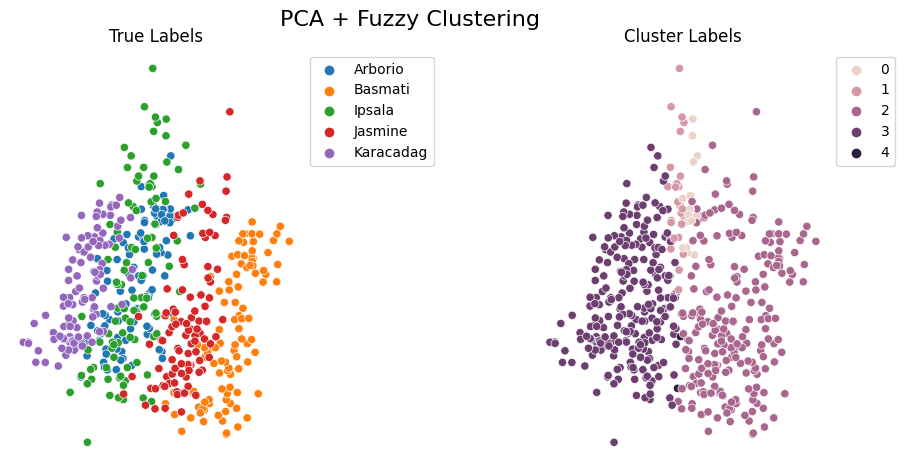

In [178]:
# Uso PCA

n_components = 100

scaler = StandardScaler()
scaled = scaler.fit_transform(sample_features)

pca = PCA(n_components=n_components)
scaled_pca = pca.fit(scaled)
Xpca = pca.transform(scaled)

exp_var = scaled_pca.explained_variance_ratio_
# varexp_acum = np.cumsum(exp_var)

# fig, ax = plt.subplots()
# ax.plot(varexp_acum)
# ax.set_title('Varianza Explicada Acumulada', fontsize=8)
# plt.show()

n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(Xpca.T, 
                                                 n_clusters, 
                                                 2, 
                                                 error=0.005, 
                                                 maxiter=1000, 
                                                 init=None)

# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

# fig, ax = plt.subplots()
# ax = sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels)
# ax.set_xlabel(f"PC1 ({'{0:.2f}%'.format(exp_var[0]*100)})")
# ax.set_ylabel(f"PC2 ({'{0:.2f}%'.format(exp_var[1]*100)})")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = sample_labels, ax=ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(x = Xpca[:,0], y = Xpca[:,1], hue = cluster_membership, ax=ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.suptitle("PCA + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

In [179]:
cross_tab(Labels_orig=sample_labels, Labels_clust=cluster_membership)

RAND score=0.6897, Ajusted RAND=0.3059, cantidad_de_muestras=500


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,12,0,5,0,0
1,14,0,15,0,0
2,13,100,12,94,0
3,61,0,67,5,100
4,0,0,1,1,0


/home/nachengue/fundar/python_projects/unsupervised-rice-image-segmentation/.venv/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


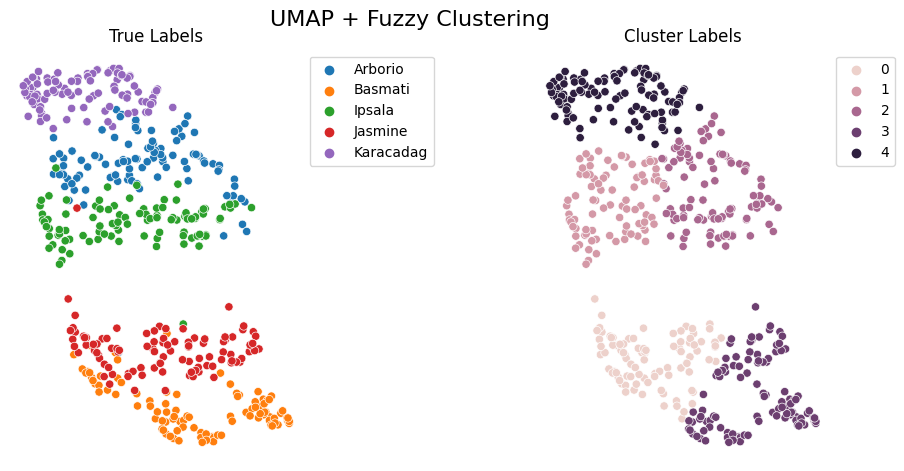

In [176]:
# Uso UMAP

umap = UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42
)

# Hago el fuzzy clustering
standard_embedding = umap.fit_transform(scaled)
n_clusters = 5
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(standard_embedding.T, 
                                                 n_clusters, 
                                                 2, 
                                                 error=0.005, 
                                                 maxiter=1000, 
                                                 init=None)

# Plot assigned clusters, for each data point in training set
cluster_membership = np.argmax(u, axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = sample_labels, ax= ax1)
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1, 1))
sns.scatterplot(x = standard_embedding[:,0], y = standard_embedding[:,1], hue = cluster_membership, ax=ax2)
sns.move_legend(ax2, "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
fig.suptitle("UMAP + Fuzzy Clustering", fontsize=16)
ax1.set_title("True Labels")
ax1.axis('off')
ax2.set_title("Cluster Labels")
ax2.axis('off')
plt.subplots_adjust(left=0.1, wspace=0.8, top=0.9)
plt.show()

In [177]:
cross_tab(sample_labels, cluster_membership)

RAND score=0.8394, Ajusted RAND=0.4968, cantidad_de_muestras=500


Labels_orig,Arborio,Basmati,Ipsala,Jasmine,Karacadag
Labels_clust,,,,,
0,1,27,1,62,0
1,37,0,51,1,0
2,50,0,48,0,0
3,0,73,0,37,0
4,12,0,0,0,100
